# PyTorch-Tides example fitting to a tidal station
This is a simple example where we fit a simple PyTorch-Tides astronomical model to a specific tidal station.

First we load the data downloaded from: (Important: Export as UTC date time format)
https://www.isdm-gdsi.gc.ca/isdm-gdsi/twl-mne/inventory-inventaire/interval-intervalle-eng.asp?user=isdm-gdsi&region=PAC&tst=1&no=7735

The data specifies water level height in meters with respect to chart datum. Timerange spans 2013-01-01  8:00:00 AM to 2022-05-01  7:00:00 AM.

In [1]:
# Load the data
import pandas as pd

# Load the training data, vancouver.csv
df = pd.read_csv('vancouver.csv', parse_dates=True, skiprows=8, header=None, names=["Time","Height"], usecols=[0,1])

# Convert to UTC datetime series
df["Time"] = pd.to_datetime(df["Time"],utc=True)

# Add timestamp column
df["Timestamp"] = df["Time"].apply(lambda x: int(x.timestamp()))

print(df.head())
print(df.shape)

# Split into train and test according to time
df_train = df[df.Time < '2020-01-01']
df_test = df[df.Time >= '2020-01-01']

print(f"Train: {df_train.shape}, Test: {df_test.shape}")

                       Time  Height   Timestamp
0 2013-01-01 08:00:00+00:00    1.30  1357027200
1 2013-01-01 09:00:00+00:00    0.97  1357030800
2 2013-01-01 10:00:00+00:00    0.98  1357034400
3 2013-01-01 11:00:00+00:00    1.42  1357038000
4 2013-01-01 12:00:00+00:00    1.99  1357041600
(82334, 3)
Train: (61194, 3), Test: (21140, 3)


## Astronomical constant calculation
We need to calculate all the astronomical constant values over the timerange.

In [2]:
import pytorch_tides
#from pytorch_tides.tides.astro_cache import AstroCache
from pytorch_tides.tides.tide_net import TideNetSingle

# Create a TideNetSingle model
tide_net = TideNetSingle()

# Cache the astronomical data for the times, this speeds up the forward passes later
tide_net.cache_times(df['Time'].unique()) # This takes about two minutes


## Fit the astronomical tidal model using PyTorch

In [3]:
import torch
import torch.utils.data as data_utils

def create_dataloader(df, target, features, times, batch_size, shuffle=True):
    td = data_utils.TensorDataset(torch.tensor(df[features].values), torch.tensor(df[[target]].values), torch.tensor(df[times].values, dtype=torch.long))
    return torch.utils.data.DataLoader(td, batch_size=batch_size, shuffle=shuffle)


def predict(net, ldr_data, length=None):
    loss = 0.0
    target_predicted = None
    target_truth = None

    for (batch_idx, batch) in enumerate(ldr_data):
        X, Y, T = batch
        
        target_new = net(T)

        # Append the data
        if target_predicted is None:
            target_predicted = target_new[:,0].tolist()
        else:
            target_predicted += target_new[:,0].tolist()
        
        if target_truth is None:
            target_truth = Y[:,0].tolist()
        else:
            target_truth += Y[:,0].tolist()
        
        if length != None and len(target_truth) > length:
            target_predicted = target_predicted[0:length]
            target_truth = target_truth[0:length]
            break
    
    return (target_truth, target_predicted)



In [4]:
batch_size = 256
ldr_train = create_dataloader(df_train, target="Height", features=[], times='Timestamp', batch_size=batch_size)
ldr_test = create_dataloader(df_test, target="Height", features=[], times='Timestamp', batch_size=batch_size)

In [5]:

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import mean_absolute_error

optimizer = torch.optim.Adam(tide_net.parameters(), lr=0.002)
loss_func  = nn.L1Loss()

for epoch in range(0, 30):
    epoch_loss = 0.0
    
    for (batch_idx, batch) in enumerate(ldr_train):
        X, Y, T = batch # Note: X is not used in a single-location model. It'd normally be latitude and longitude.

        prediction = tide_net(T)     # input x and predict based on x

        loss = loss_func(prediction, Y)     # must be (1. nn output, 2. target)

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients

        # Epoch loss
        epoch_loss += loss.item()

    (y_true, y_predicted) = predict(tide_net, ldr_test)
    mae_test_ml = mean_absolute_error(y_true, y_predicted)

    print(f'Epoch: {epoch}, Epoch loss: {epoch_loss}, Validation MAE: {mae_test_ml}')


Epoch: 0, Epoch loss: 905.5048179626465, Validation MAE: 3.29477476935152
Epoch: 1, Epoch loss: 665.0522525310516, Validation MAE: 2.3733179996872447
Epoch: 2, Epoch loss: 474.5756005048752, Validation MAE: 1.6403153682119576
Epoch: 3, Epoch loss: 316.51678842306137, Validation MAE: 1.0153324789850846
Epoch: 4, Epoch loss: 178.33777910470963, Validation MAE: 0.47858099839438095
Epoch: 5, Epoch loss: 71.51767577975988, Validation MAE: 0.16493715712214163
Epoch: 6, Epoch loss: 31.31179329752922, Validation MAE: 0.12708069527424545
Epoch: 7, Epoch loss: 28.612597316503525, Validation MAE: 0.12227560355815602
Epoch: 8, Epoch loss: 28.092455312609673, Validation MAE: 0.11956956211403506
Epoch: 9, Epoch loss: 27.571002788841724, Validation MAE: 0.11896294503056691
Epoch: 10, Epoch loss: 27.40709363669157, Validation MAE: 0.11666144367489989
Epoch: 11, Epoch loss: 27.248747803270817, Validation MAE: 0.11820906516793998
Epoch: 12, Epoch loss: 27.177293099462986, Validation MAE: 0.1170202287571

## Visualize the model predictions versus measured tidal heights

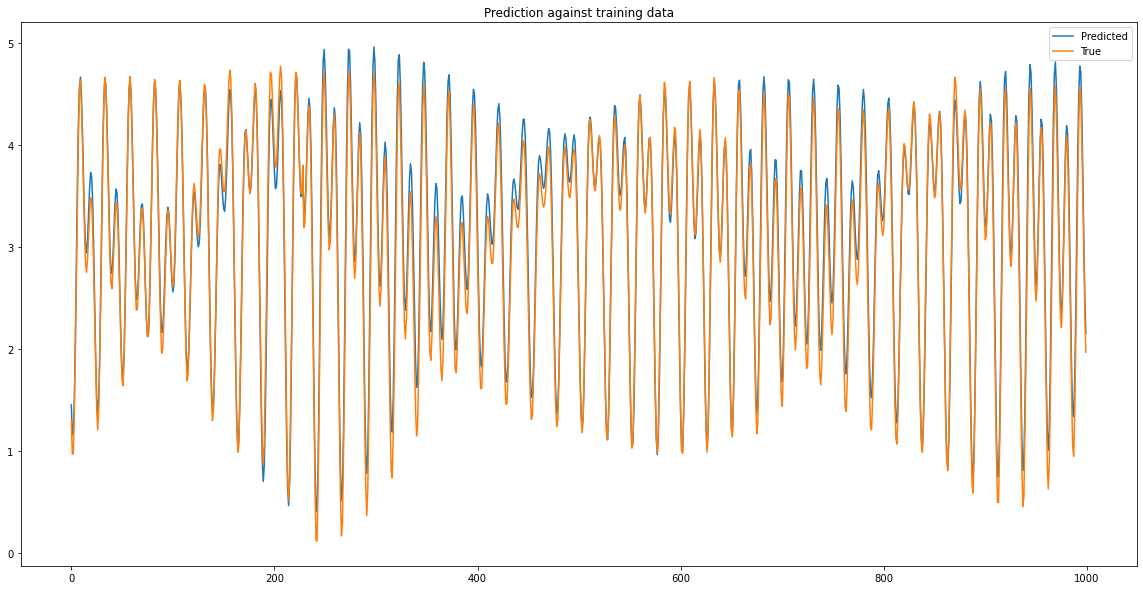

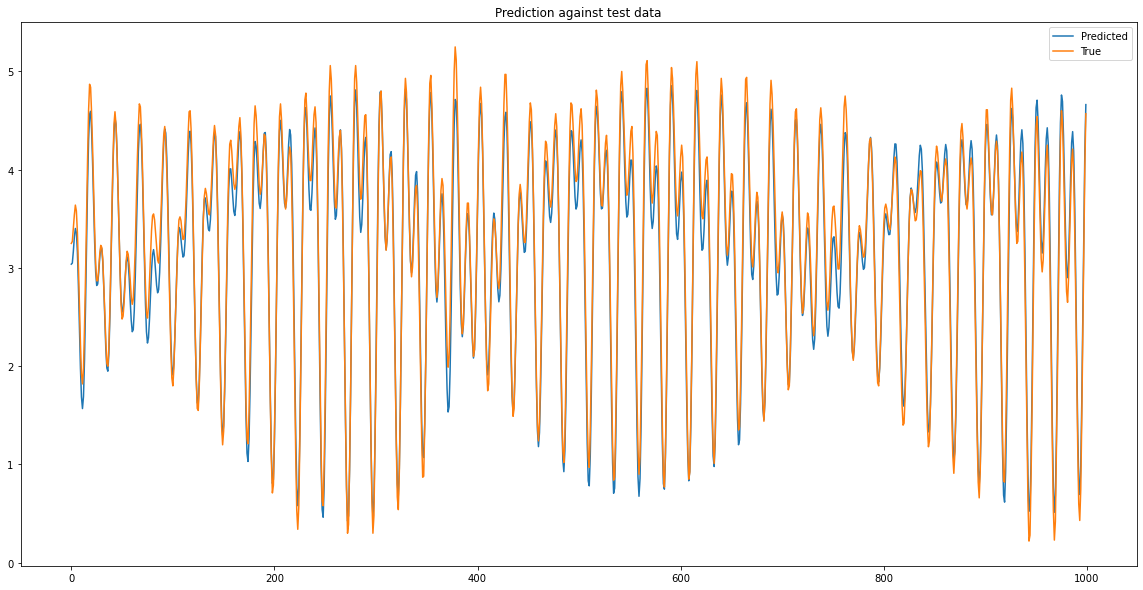

In [6]:
import matplotlib.pyplot as plt

# Create unshuffled dataloaders for plotting
ldr_train = create_dataloader(df_train, target="Height", features=[], times='Timestamp', batch_size=batch_size, shuffle=False)
ldr_test = create_dataloader(df_test, target="Height", features=[], times='Timestamp', batch_size=batch_size, shuffle=False)


# Plot the first 100 entries of the training data and test data versus the predicted tide heights
length = 1000

(y_true, y_predicted) = predict(tide_net, ldr_train)
plt.figure(figsize=(20, 10))
plt.plot( range(length), y_predicted[0:length], range(length), y_true[0:length] )
plt.title('Prediction against training data')
plt.legend(['Predicted', 'True'])

(y_true, y_predicted) = predict(tide_net, ldr_test)
plt.figure(figsize=(20, 10))
plt.plot( range(length), y_predicted[0:length], range(length), y_true[0:length] )
plt.title('Prediction against test data')
plt.legend(['Predicted', 'True'])


## Create and plot tidal predications for a specified time period

Text(0.5, 1.0, 'Tide Prediction for Vancouver at 2024-01-01 00:00:00+00:00 to 2024-01-10 23:54:00+00:00')

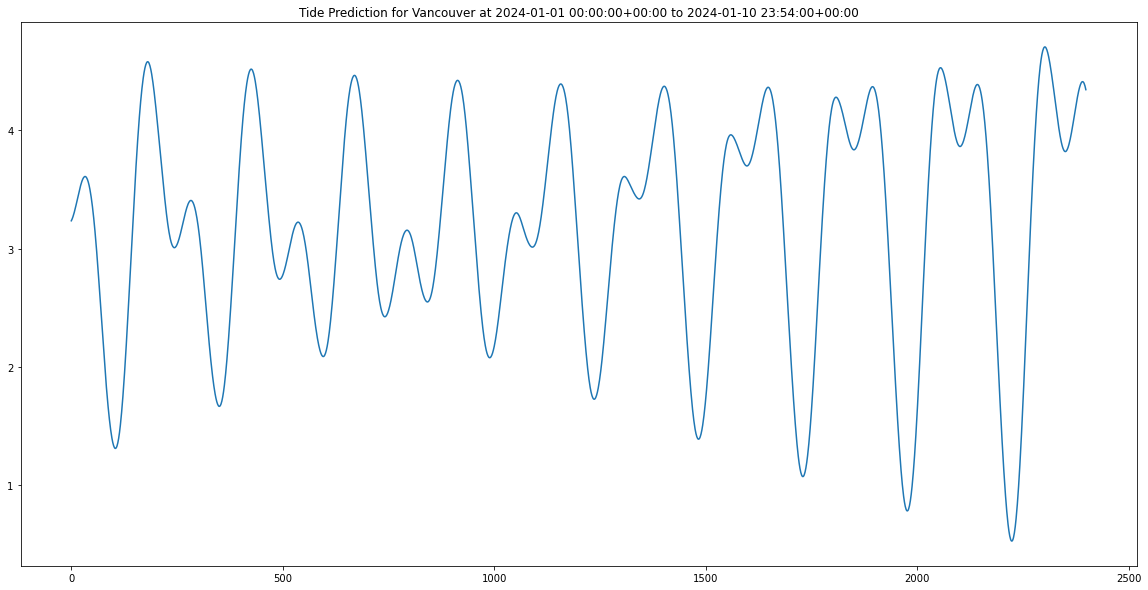

In [7]:
import datetime
from datetime import timezone

# Make a preduction for a specific location
time = datetime.datetime(2024, 1, 1, 0, tzinfo=timezone.utc)
data = []
for i in range(24*10*10): # 10 days, 10 predictions per hour.
    new_entry = {}
    new_entry["Timestamp"] = int(time.timestamp())
    new_entry["Time"] = time
    new_entry["Height"] = 0

    time += datetime.timedelta(hours=0.1)

    data += [
        new_entry
    ]

df_simulate = pd.DataFrame(data)

# Update astro cache
times = df_simulate['Time'].unique()
tide_net.astro.add_times_to_astro(times)

loader = create_dataloader(df_simulate, target="Height", features=[], times='Timestamp', batch_size=batch_size, shuffle=False)
y_true, y_predict = predict(tide_net, loader)

plt.figure(figsize=(20, 10))
plt.plot( range(len(y_predict)), y_predict )
plt.title(f'Tide Prediction for Vancouver at {times[0]} to {times[-1]}')


#df = pd.DataFrame(y_predict)
#df.to_csv("test_output.csv")